# Assignment 3
## Statistical inference, bootstrap and model comparison

**In this assignment, we will see how to compute bootstrapped confidence intervals and how to do model comparison.**

- Learn how to use bootstrapping to generate new sample datasets
- Estimate our model parameter on these new sample datasets
- Quantify the variance of our estimate using confidence intervals

- Parametric model comparison with AIC, BIC
- Cross-validation for model selection






<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

The following resources will help you to get ready to complete this assignment. <br>
Watch <a href="https://youtu.be/9JfXKmVB6qc?t=910" target="_blank">the second part of this video</a> to have a quick overview of how to assess model fits. Remember that all types of regression analysis and statistical test can be seen as testing how well a generative model (i.e. a linear model with noise) can explain your data. Then watch these series of short videos on more specific topics (all these videos are taken from the <a href="https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/chapter_title.html" target="_blank">tutorials of the Model Fitting day at Neuromatch Academy</a>):
        <li><a href="https://youtu.be/hs6bVGQNSIs" target="_blank">this video</a> on bootstrapping the estimate the confidence intervals for your model parameters</li>
        <li> <a href="https://youtu.be/NcUH_seBcVw" target="_blank">this video</a> on the bias-variance trade-off, which provides the conceptual basis for model selection, i.e. finding a model that fits the data well while keeping model complexity as low as possible. For statistical analysis, this is equivalent to look for the significant effects as components that we must include in the model in order to capture the structure of the data.</li>
        <li> <a href="https://youtu.be/OtKw0rSRxo4" target="_blank">this video</a> about how to perform model comparison in practice by testing the model on a test set (i.e. a part of the dataset that was not used for estimating the parameters), and how this is generalized in <b>cross-validation</b></li>

---
# Setup

We will keep working on the same example as in Assignment 2 (psychometric curves and logistic regression).

We start by importing the typical libraries, importing the data as a dataframe and adding the relevant columns.

In [ ]:
#1. Load the packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm


# 2. load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A2_LogisticRegression/Experiment1_all_subjects.csv")

# 3. Define a function that takes two angles as input and outputs the angular distance between the two
def circdist_deg(angles1,angles2): #define the name and set the arguments between parentheses
    angle_diff = angles2 - angles1 # simple difference
    angle_diff_rad = angle_diff*np.pi/180 # convert to radians
    angular_dist_rad = np.angle( np.exp(1j*(angle_diff_rad))) ## mathematical operation to get the circular distance (in radians)
    angular_dist = 180/np.pi*angular_dist_rad ## convert back to degrees
    output = np.round(angular_dist) # round value to eliminate numerical imprecisions (all values are integer)
    return output #return the circular distance in degrees 

# 4. Compute the displacement of the probe from the target and add it as a new column to the dataframe: 
df['displacement'] = circdist_deg( df['target'], df['probe'] );

# 5. change the column 'response': all -1's become 1's and 1s become 0's
df.response *= -1 # multiply by -1, so now 1 codes for CCW and -1 for CW
df.loc[df.response==-1, 'response'] = 0 # convert -1s to 0s, so now 1 codes for CCW and 0 for CW



**Helper functions**

There is nothing really new here as these functions were already used in Assignment 2. They are here to make your life easier. Have a look at what they are doing and use them in your code below.

In [ ]:

def logistic(x):
    """
    Returns the output of the logistic function for the given input value (float or array-like).
    """
    y = 1 / (1 + np.exp(-x))
    return y

def psychometric_model(d, w0, w1):
    """
    Compute the psychometric function based on a simple logistic model. 
    Args:
       d (ndarray): input values.
       w0 (float): intercept for logistic regression.
       w1 (float): slope for logistic regression.
    Returns:
       ndarray: The `y` data points of the psychometric function. 
          In our case, this corresponds to the probability of CCW responses.
    """
    p = logistic(w0 + w1*d)
    return p

def plotcurve(df, color):
    """
    Plot the fitted psychometric curve with experimental datapoints on top. 
    Args:
       df (dataframe): experimental data
       color (string): color of the datapoints and fitted line
    """

    mod = smf.glm(formula='response ~ displacement', data=df, family=sm.families.Binomial())
    res = mod.fit()
    
    myx = np.linspace(-20,20,100)
    yfit=res.predict(pd.DataFrame({'displacement': myx})) #yfit = res.predict(exog={'probe_target':myx})

    # plot the psychometric function (fit)
    plt.plot(myx,yfit,'-', color=color,label='fit')
    
    # plot the psychometric curve (datapoints)
    df.groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', color=color, fmt = 'o', ax=plt.gca(), label='data');
    

**Show psychometric curve for subject 1**

Your first task is to use the provided function `plotcurve` to plot the psychometric curve of subject 1.
- Select the data of subject number 1
- Use the pre-defined functions from above to plot the psychometric curve (datapoints and fit).

*For parts 1 and 2 of this assignment, we will work with the data of this subject.*

In [ ]:
# select subject 1
ds = ??

# plot the psychometric curve
fig, ax = plt.subplots()
??
ax.set(xlabel='displacement (degrees)', ylabel='p(CCW)');
ax.legend();

---
# 1. Bootstrapping

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets, here we use 2000.

To explore this idea, we will work with the data from subject 1 and consider a simple logistic regression model for predicting the subject's responses from the angular displacement of the target and probe.

## 1.1 Resample Dataset with Replacement

In this exercise you will implement a method to resample a dataset with replacement. The method accepts $\mathbf{x}$ and $\mathbf{y}$ arrays. It should return a new set of $\mathbf{x}'$ and $\mathbf{y}'$ arrays that are created by randomly sampling from the originals.

We will then compare the original dataset to a resampled dataset.


**Hint:** The [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method will be useful here. Before you start to implement the resampling function, first make sure that you understand the following two lines of code.

In [ ]:
print(np.random.choice(10, size=10, replace=False))
print(np.random.choice(10, size=10, replace=True))

**Complete the following function which we will use to generate the bootstrap samples**

In [ ]:

def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """

  # Get array of indices for resampled points
  sample_idx = ??

  # Sample from x and y according to sample_idx
  x_ = ??
  y_ = ??

  return x_, y_


**Generate resampled data and display the psychometric curves for the original and the resampled data.**

Repeat this several times to get a feeling for the "randomness", that is how different the resampled data is from the original data.
Note that `values` (in the first line) returns the numerical data contained in the dataframe (a numpy array).

In [ ]:
# resample the data
x_, y_ = resample_with_replacement(ds.displacement.values, ds.response.values)

# place the resampled data in a dataframe
ds_resampled = pd.DataFrame(??)

# plot the psychometric curve
fig, ax = plt.subplots()
??
??
ax.set(xlabel='displacement (degrees)', ylabel='p(CCW)');
plt.legend(('Original','Resampled'));


Now that we have a way to resample the data, we can use that in the full bootstrapping process.

## 1.2 Bootstrap Estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of logistic regression weights $w_0$ and $w_1$ from a dataset of inputs ($\mathbf{x}$, the displacement of target and probe) and  measurements ($\mathbf{y}$, the subject's responses). You should use `resample_with_replacement` here.

We will then use this function to look at the $w_0$ and $w_1$ values obtained from different samples.

First complete the following function that runs a simple logistic regression as in Assignment 2.
Just as a reminder, we consider the influence onto our binary variable (choices) of a single variable: the displacement of the probe w.r.t the target stimulus (the parameter that controls the difficulty of the trial).
Defining this function is useful because the only result that we want to store for the 2000 bootstrap samples are the values of the regression weights $w_0$ and $w_1$ and with the function our later code will be easier to read.


In [ ]:
# @markdown Execute this cell for helper function `solve_log_regression`
def solve_log_regression(df):
    """Solve the logistic regression

    Args:
    df:dataframe

  Returns:
    two floats: the value for w0 and w1 for the fitted model
    """

    # declare the logistic regression model
    mod = smf.glm(??)

    # fit the model
    res = ??

    return res.??, res.??

**Use your function to estimate the regression weights for the original data and the resampled data from above** (just to see if everything works correctly.

In [ ]:
w0,w1 = solve_log_regression(ds)
print("original data:")
print("w_0 = ", w0,"w_1 = ", w1)
w0_resampled,w1_resampled = solve_log_regression(ds_resampled)
print("resampled data:")
print("w_0 = ", w0_resampled,"w_1 = ", w1_resampled)

**We are now ready to implement the bootstrap function**

In [ ]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute
  Returns:
    ndarray: An array of estimated parameters with size (n,2)
  """
  theta_hats = np.zeros((n,2))

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = ??
    df_resampled = ??

    # Compute theta_hat for this sample
    theta_hats[i,:] = solve_log_regression(??)

  return theta_hats

# For testing purposes we set the random seed so that we always get the same result
np.random.seed(123)

# Get bootstrap estimates (generate only 3 bootstrap samples for a quick check if everything works)
theta_hats = bootstrap_estimates(ds.displacement.values, ds.response.values, n=3)

# Now we initialize the random number generator so that we get different random numbers from now on.
np.random.seed()

print(theta_hats)


You should see `[[0.34574091 0.12517866] [0.25904594 0.11718731] [0.05620029 0.14365177]]` as the first three estimates.

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are. Note that now we want to generate 2.000 bootstrap samples and fitting the corresponding logistic regression models can take a few seconds (depending on your machine).

In [ ]:

x = ??
y = ??

fig, ax = plt.subplots()

# Generate bootstrap samples and fits
theta_hats = bootstrap_estimates(??)

# For each theta_hat, plot model
myx = np.linspace(-20,20,100)
for i, theta_hat in enumerate(theta_hats):
  y_hat = psychometric_model(myx, theta_hat[0], theta_hat[1])
  ax.plot(myx, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
??

ax.set(
  title='Bootstrapped Parameter Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend();

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--');


This looks pretty good! The bootstrapped estimates spread around the observed datapoints, as we would have hoped.  As always it is a good idea to visually inspect the quality of estimates.
Now you can try to run the bootstrap procedure on all the subjects together (just taking all the data, ignoring the subject identity). **What happens to the spread of the bootstrap estimates? (insert your answer below)**


??

---
# 2. Confidence Intervals

Let us now quantify how uncertain our estimated parameters ($w_0$ and $w_1$) is. We do so by computing [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (CIs) from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

## 2.1 Plot bootstrap samples and confidence intervals

**Hint**: you can use `np.percentile`.


In [ ]:
# to run the analysis for all subjects, uncomment the following 3 lines
#x = df.displacement.values
#y = df.response.values
#theta_hats = bootstrap_estimates(x, y, n=2000)

means = np.mean(theta_hats,axis=0)
stds = np.std(theta_hats,axis=0)
medians = ??
CIs = ??

# insert below your code that displays two histograms (one for the bootstrap samples of $w_0$ 
# and one for the bootstrap samples of $w_1$)
# display vertical lines to indicate the confidence interval and the original data

??







**Are the responses of this subjects biased?** (Hint: the bias is reflected in $\hat{w_0}$). 

<< add your answer here >>

It's a good idea to **repeat the analysis with a different subject or with all subjects pooled together** in order to get a better intuition about the datapoints, fitted psychometric curve and confidence intervals for the fitted parameters.

## 2.2 Comparison with confidence intervals obtained by Python


Finally, compare the confidence intervals obtained using bootstrap with the confidence intervals reported by `sm.glm`.
Also compare the standard deviation of the bootstrapped parameter estimates to the std err reported by `sm.glm`.

Note that the code below uses [f-Strings](https://realpython.com/python-f-strings/#f-strings-a-new-and-improved-way-to-format-strings-in-python), a convinient way of displaying numbers with a certain format (e.g. number of digits after the comma). 

In [ ]:
print(f"                   mean      std        [0.025      0.975]")
print(f"----------------------------------------------------------")
print(f"w0               {means[0]:.4f}      {stds[0]:.3f}       {CIs[0,0]:.3f}       {CIs[1,0]:.3f}")
print(f"w1               {means[1]:.4f}      {stds[1]:.3f}       {CIs[0,1]:.3f}       {CIs[1,1]:.3f}")
print(f"==========================================================")

In [ ]:
# declare the logistic regression model
mod = smf.glm(formula= 'response ~ displacement' , data = ds, family = sm.families.Binomial() )

# fit the model
res = mod.fit()

# print results as a summary table
print(res.summary())

**Discuss your results below:**

**Optional question: what is the relationship between the standard error of the mean (sem) and the standard deviation of the bootstrap samples?**

<< your answer here >>

---
## Summary of bootstrapping

- Bootstrapping is a resampling procedure that allows to build confidence intervals around inferred parameter values
- it is a widely applicable and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)
- is non-parametric: the confidence intervals provided by statistical libraries are not always accurate because they assume an underlying gaussian distribution for parameters, which is not always the case.

# 3. Model comparison using penalized likelihood
In traditional statistics, we test the presence of an effect in the data by assessing if it is credible that the effect is absent, i.e. whether the null hypothesis (the absence of the effect) can be rejected. This is what we have done in the previous section, we tested whether a null value for the regression weights is plausible. But the validity of the alternative hypothesis is never tested directly.

Now, using the framework of statistical modelling offers a richer set of tools because we can **directly compare the null hypothesis and the alternative hypothesis** and assess which one better accounts for the experimental data. The approach is even more generic: the tools of statistical modelling / machine learning allows to directly compare any statistical models based on some dataset.

In previous assignments, we have seen two metrics that assess how well a model captures the data:
- the mean-squared error, in the case of linear regression (the smaller the better)
- the (log-)likelihood, which can be used in all settings (the larger the better). Remember that the maximum-likelihood approach is actually equivalent to the minimum-squared error for linear regression, but works in other cases.
We have used these two metrics to decide, given a certain parametric model of the data (i.e. linear regression), which set of parameters better describe the data. But the same philosophy can be used to decide which of two different models better describes the data: the larger the likelihood, the better the model.

Yet there is a caveat. The likelihood is usually estimated for each model at the maximum-likelihood parameters. But if a certain model has more parameters, then there is larger space of parameters to maximize the likelihood, i.e. the model is more flexible, so it will receive an unfair advantage when comparing the likelihoods with other models. Even if those extra parameters do not contribute anything to capturing the true processes that underlie the generation of the data, giving this extra-flexibility can allow it to improve the likelihood simply by adjusting to noise. This is the problem of **overfitting**. In the videos, we have seen that we need to find a right balance between fitting the data and model parsimony, what is know as the **bias-variance trade-off**. 

To make the comparison more fair between models of different complexities, one approach is simply to apply a certain penalty term on top of the likelihood that penalizes the models with more parameters. The two most popular metrics for doing so just differ in the strength of the penalty term: 
- the **Akaike Information Criterion (AIC)** is computed as $AIC = 2k - 2 \hat{LLH}$, where $k$ is the number of parameters of the model (i.e. a simple linear regression model will have two, the intercept and the slope) and $\hat{LLH}$ is the log-likelihood of the model estimated at the maximum-likelihood parameters (the value that is provided in the summary of the model after fitting).
- the **Bayesian Information Criterion (BIC)** is computed as $BIC = k \log n - 2 \hat{LLH}$ where $n$ is the number of observations (i.e. trials).
The smaller the AIC (or BIC), the better is the model, because of the negative sign before the log-likelihood. The first part of the equation is positive and correspond to the penalty term. That term is larger in the case of the BIC, i.e. the BIC penalizes more severely models with many parameters than the AIC. In other words, it will be more conservative in rejecting the null hypothesis. It's important to note that these are **relative measures**: their raw values tell us very little, it's only by comparing values between different models that we can interpret which model better captures the data. So we cannot conclude from the BIC/AIC that one model is a good model of the data; only that it is a better model of the data than others. 

Akaike's rule of thumb: **two models are essentially indistinguishable if the difference of their AICs is less than 2** (same for BIC). The larger the difference, the more evidence towards the better model against the other.

But enough talking, let's see how to apply this in practice. We will look back to the analysis that suggests that, in memory trials, the relative position distractor has an impact on the choice of the participants.

First, fit a **logistic regression model with probe displacement and distance of the distractor as regressors, restricting the analysis to memory trials** (i.e. delay of 1s or 3s). 
Unlike what we did in the previous assignment where we analyzed data from all subjects together without taking into account the population heterogeneity, the good practice is to apply statisical modelling on a single-subject data (or used mixed-effects models as we saw in Assignment 2B). Here we will **work on on the data for one subject only: subject 5**.

In [ ]:
#Compute the distance between the distractor and the target and add as a new column to the dataframe:
df['dist_distractor'] = circdist_deg( df['target'] , df['near'] )

# we restrict the dataframe to memory trials and trials from subject 5
memory_trials_subject5 =  ??

# dataframe for memory trials and subject 5
df_memory = ??

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset. 
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_memory = df_memory.reset_index(drop=True)

# declare the logistic regression model
??

# fit the model
??

# print results as a summary table
??

We will want to compare this model to the null model, which is exactly the same but where the influence of the distractor is removed. **Fit the null model**.

In [ ]:
???

Let us first **compare the log-likelihood of both models**. This value (provided in the summary) is given by `res.llf`.

In [ ]:
print("LLH for the model with distractor: " + str(??))
print("LLH for the null model: " + str(??))

**What do you observe? Is it expected?**

??

(Optional) The value of the AIC is directly provided by `statsmodel` as `res.aic`.
**Check that the value corresponds to the formula provided above** (the list of parameters of the model is given by `res.params`).

In [ ]:
# AIC
print(res.aic)

# Use the formula
nParam = ??
print(??)

Now **compare the AIC from the two models**.

In [ ]:
???

**Interpret the results.**

**Compare the BIC from the two models** (use  `res.bic_llf`, not `res.bic`).

In [ ]:
???

**Interpret the results.**

??

**(Optional)** Now run the analyses again with subject 3. What do you conclude for this subject?

??

# 4. Testing model performance on held out data
The AIC and BIC are convenient because they are easy to compute, but they are just "approximately good". For large sample size, they work well, but for smaller sample size they may not accurately describe which model is better. Moreover, as we have seen, they sometimes provide contradictory results, which is always frustrating.

Another approach for comparing models on experimental data while adjusting for model complexity is to test the model performance on datapoints that have not been used to train/fit the model (i.e. estimated the maximum-likelihood parameters). If a model with many parameters is overfitting, i.e. its parameters are adjusted to predict very well the datapoints it was trained on (it is fitting 'noise'), then its performance may decrease severely when testing the model with the same parameters but on a new dataset. 
How this is done in practice is that we **split our datasets into two smaller datasets**: one **training set** which is used to fit the model and extract the maximum-likelihood parameters, and one **test set** (or held-out data) which is used to evaluate the performance of the model previously fitted. This method naturally corrects for model complexity when comparing different models. Let us do this.

The first step is to divide our dataset in two. In general the training set is the larger, usually taking 80% of the data, while the test set takes the remaining 20%.
This can be done using `train_test_split` from `statsmodel`, which randomly assign each observation to either the train or test set, while controlling for the relative size of each set. 

In [ ]:
# import train_test_split
from sklearn.model_selection import train_test_split

# make sure to use again data for subject 5!
???

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset. 
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_memory = df_memory.reset_index(drop=True)

# create two dataframes. Parameter test_size (between 0 and 1) controls the relative size of the test set.
df_train, df_test = train_test_split(??, test_size=??)

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset. 
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_test = df_test.reset_index(drop=True)

Check the size (number of rows) of the train and test sets. Check how this is affected by changing the `test_size` parameter.

In [ ]:
???

If you were to sample the data "manually" to split between the train and test sets (instead of using `train_test_split`), would you set the `replace` option of `np.random.choice` to `True` or `False`?

Now, let's follow the procedure:
- **fit both models (with or without distractor regressor) to the train set**
- **use the fitted models to generate predictions for the probability of CCW response on the test set**. (Remember we in Assignment 2B we saw how to use `res.predict`)

In [ ]:
# fit model with impact of distractor on training set
???

# fit null model on training set
???

# use the fitted statistical model to compute p(CCW) for each value in this dataframe
???

We now have a prediction for each trial in the test set, and what we want is a single metric, the LogLikelihood on the test data, to compare the models. There are no built-in method in `statsmodel` for computing the log-likelihood on test data, so we use the following function:

In [ ]:
# compute likelihood of test data
def loglikelihood_binary(pModel, resp):
    """Computes the log-likelihood of binary dataset for a given model.
  Args:
    pModel (ndarray): An array of shape (samples,) that contains the probability 
    of response 1 according to the model
    resp (ndarray): An array of shape (samples,) that contains the binary data
  Returns:
    LLH: the log-likelihood of the model
  """
    
    # number of observations / trials
    n = len(pModel)
    
    # initialize log-likelihood
    LLH = 0
    
    # loop through trials
    for i in range(n):
        
        if (resp.iloc[i]==1):
            lh = pModel.iloc[i]
        else:
            lh = 1-pModel.iloc[i]
            
        # add logarithm of likelihood for the trial to LLH
        LLH += np.log(lh)
        
    return LLH

Use the function above to **compute the log-likelihood of both models on the test data**.

In [ ]:
????


**Interpret the results.**

??

# 5 Crossvalidation


That is good, but if you run the analysis again, you will notice that the results vary every time. This is because everytime you run the analysis, you generate a new random split of the dataset between the train and test sets. Obviously, our measure of which model is best should not depend on a random generator! One way of dealing with this is to perform various splitting, compute the test score for each split, and then average over splittings. The more splittings we perform, the more robust our measure will be. This is usually done using **cross-validation**, where the dataset is chunked in pieces (or folds), where each piece alternatively takes the role of the test set. The most standard form of cross-validation is K-fold cross-validation, where K describes the number of folds in which the data is split. This is illustrated below using $K=5$. The log-likelihood of cross-validated data is described as "Cross-Validated Log-Likelihood" (**CVLL**).

In general, the larger is K, the more robust your measure is. The extreme case is **leave-one-out cross-validation** (LOOCV) where basically you split the datasets in sets of just one observation (trials); then on each fold you fit all your dataset on all the dataset but one observation and test it on this single heldout observation. So LOOCV is like K-fold CV where K equals the number of observations. However, by increasing K, you also increase the computational complexity as you need to fit the model over and over, so things can get slow.

Cross-validation is a robust method for choosing the best statistical model for a certain dataset. It does not suffer the same limitations as AIC/BIC, and can be used for other metrics than the log-likelihood such as the mean squared error or the classification accuracy. This it can be used also for complex methods when the likelihood cannot be evaluated.
This is why **cross-validation is the standard method in machine learning** to compare the performance of any type of models (deep networks, auto-encoders, SVMs, etc.).

(Image taken from [https://www.askpython.com/python/examples/k-fold-cross-validation])

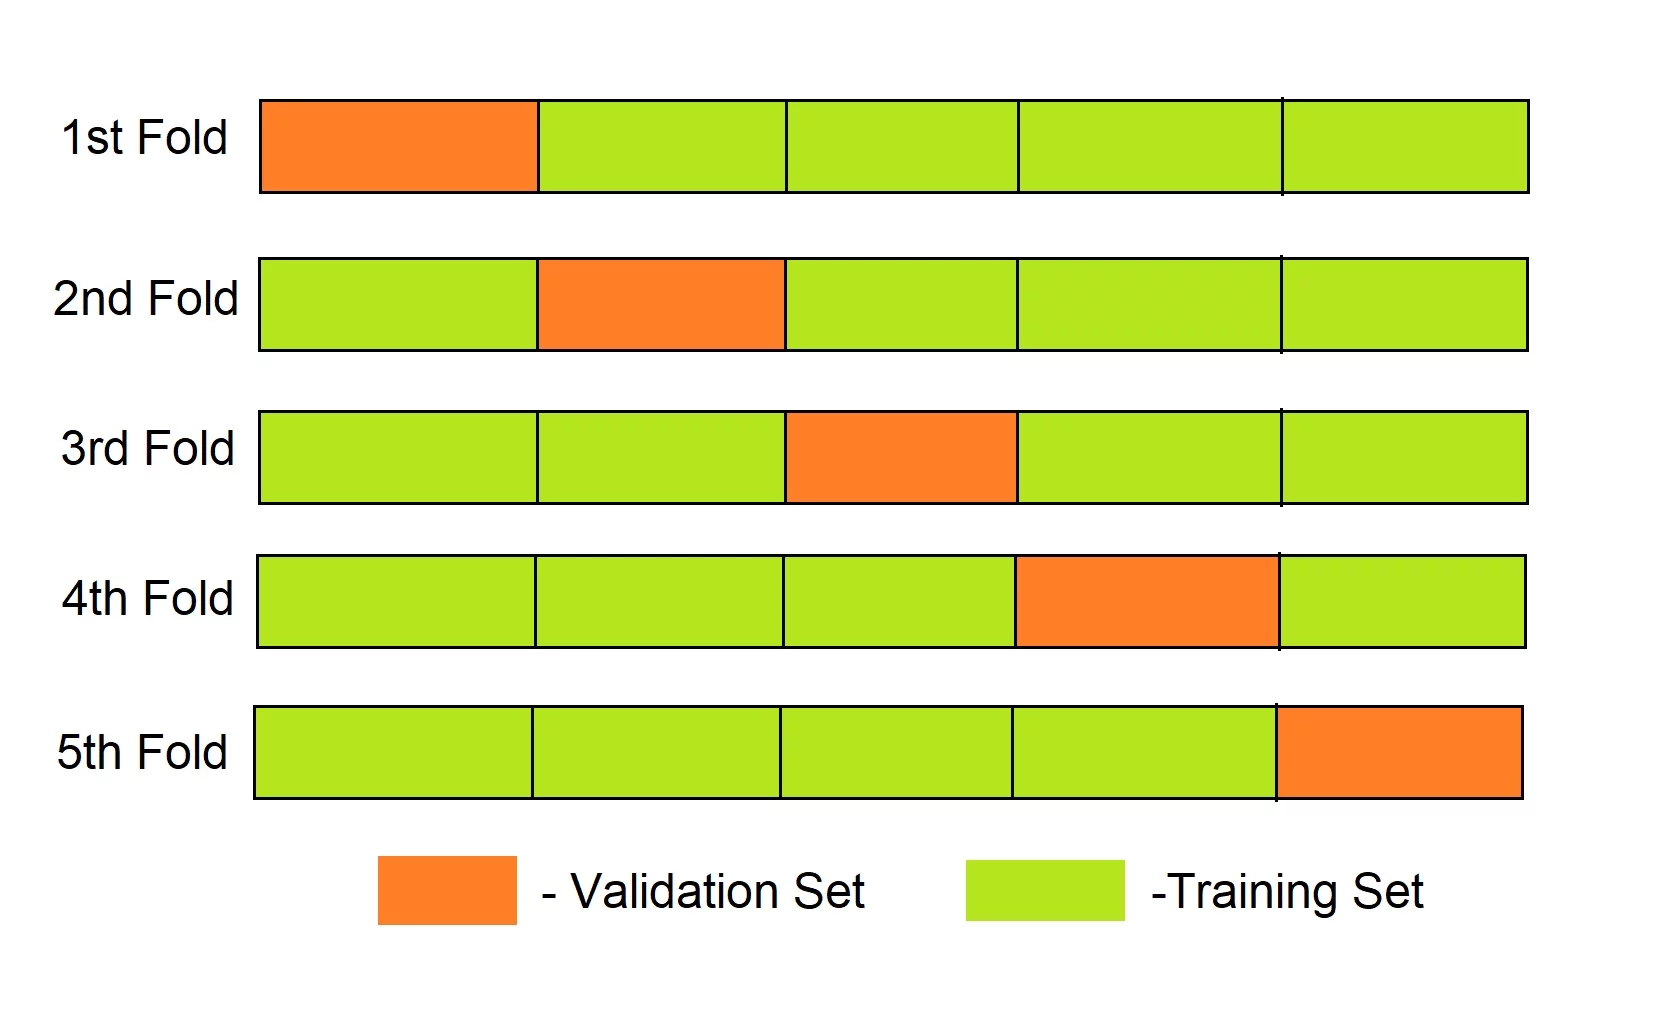

In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`). `KFold` handles cross-validation subset splitting and train/val assignments.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data. 

We will loop through the 10 train/validation splits and on each split compute the log-likelihood of both models on the test set. Then we will average the CVLL over splits.

In [ ]:
#import KFold
from sklearn.model_selection import KFold

# number of folds
K = ??

#create Kfold object
kf = KFold(n_splits = K)

**Apply K-fold validation on the dataset to compute the CVLL on both the distractor and null models.**

In [ ]:
# Initialize CVLL as numpy array with K rows and 2 columns, one for each model
CVLL_all = ??

# loop through all folds (the complex syntax provides the loop counter i, as well as the indices of trials in train and test sets for the corresponding fold)
for i, (train_index, test_index) in enumerate(kf.split(df_memory)):
    
    # dataframe with training data
    df_train = ??
    
    # dataframe with test data
    df_test = ??
       
    # fit model with impact of distractor on training set
    ???

    # fit null model on training set
       ??

    # use the fitted statistical model to compute p(CCW) for each value in this dataframe
    ??
    
    # compute the CVLL for each model
    LLH_test = ??
    LLH_test_null = ??
    
    # add as row in array
    CVLL_all[i] = ??

**Plot the difference in CVLL between the distractor model and the null model on each fold** (use a bar plot).

In [ ]:
# compute the difference of CVLL between the two models on each fold
CVLL_diff = ??

# Plot as bar plot
??

# Add axis labels
??

**Compute the average difference of CVLL across folds.**

In [ ]:
??

**What do you conclude?**